In [8]:
# %pip install pycaret[full]
# %pip install ctgan

In [118]:
from pycaret.classification import *
from ctgan import CTGAN
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.optim as optim
import numpy as np

In [14]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [2]:
df = pd.read_csv("./creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
# Check if dataset has any NaN
df.isnull().any().any()

False

In [4]:
# Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
df['Time'].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

In [5]:
2 * 24 * 60 * 60 # 2 days of data in seconds

172800

In [6]:
# Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
# Test size of 8 hours, remaining for training
test_hours = 8
train_hours = 48 - test_hours
train_delta = train_hours * 60 * 60 # Convert to seconds
train_df = df[(df['Time'] >= 0) & (df['Time'] < train_delta)]
test_df = df[df['Time'] >= train_delta]

In [8]:
train_df['Class'].value_counts()

0    224450
1       415
Name: Class, dtype: int64

In [9]:
test_df['Class'].value_counts()

0    59865
1       77
Name: Class, dtype: int64

# Baseline Models

In [68]:
cc = setup(data=train_df, target='Class', session_id=42, train_size=0.80)

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(224865, 31)"
4,Transformed data shape,"(224865, 31)"
5,Transformed train set shape,"(179892, 31)"
6,Transformed test set shape,"(44973, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


In [69]:
best_baseline_model = cc.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9996,0.9770,0.8254,0.9371,0.8757,0.8754,0.8782,6.7260
qda,Quadratic Discriminant Analysis,0.9763,0.9677,0.8705,0.0639,0.1191,0.1160,0.2322,0.1640
ada,Ada Boost Classifier,0.9992,0.9676,0.7411,0.8113,0.7718,0.7714,0.7736,4.1370
nb,Naive Bayes,0.9915,0.9666,0.6867,0.1383,0.2301,0.2277,0.3056,0.1940
rf,Random Forest Classifier,0.9995,0.9518,0.7953,0.9395,0.8605,0.8603,0.8637,7.2300
et,Extra Trees Classifier,0.9995,0.9515,0.7953,0.9469,0.8631,0.8629,0.8669,1.5410
lr,Logistic Regression,0.9991,0.9409,0.6113,0.8510,0.7072,0.7067,0.7186,1.2580
lda,Linear Discriminant Analysis,0.9993,0.9095,0.7560,0.8530,0.7993,0.7990,0.8016,0.2000
dt,Decision Tree Classifier,0.9991,0.8900,0.7804,0.7515,0.7636,0.7631,0.7643,0.9070
gbc,Gradient Boosting Classifier,0.9991,0.7755,0.6454,0.8394,0.7189,0.7185,0.7298,21.7400


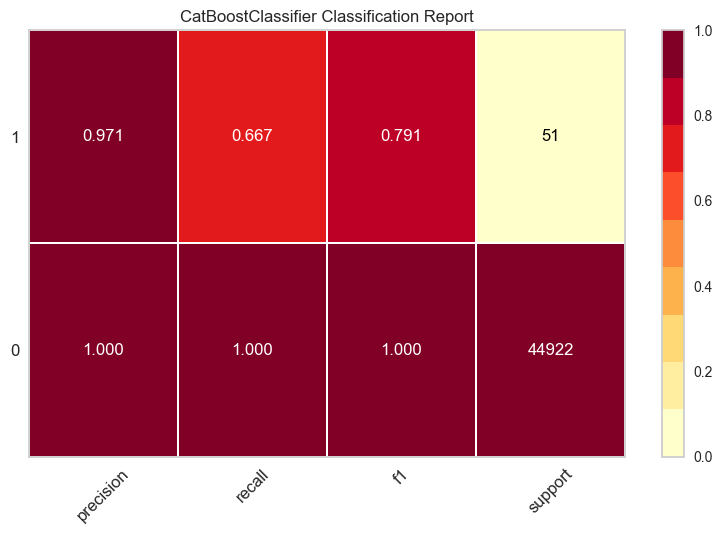

In [12]:
cc.plot_model(best_baseline_model, plot='class_report')

In [70]:
pred_df = cc.predict_model(best_baseline_model, data=test_df.copy().drop('Class', axis=1))

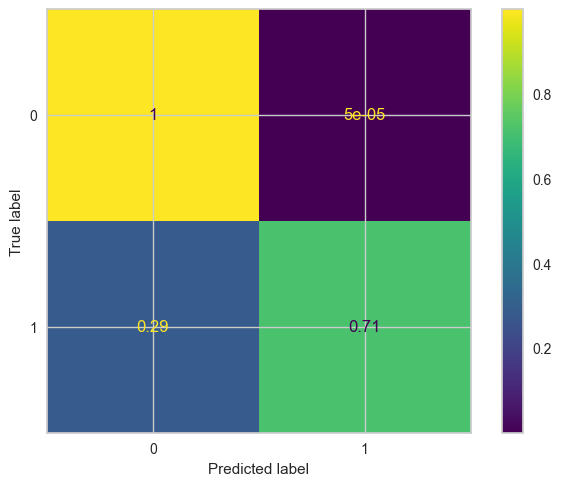

In [73]:
ConfusionMatrixDisplay.from_predictions(test_df['Class'], pred_df['prediction_label'], normalize="true")

In [74]:
print(classification_report(test_df['Class'], pred_df['prediction_label']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59865
           1       0.95      0.71      0.81        77

    accuracy                           1.00     59942
   macro avg       0.97      0.86      0.91     59942
weighted avg       1.00      1.00      1.00     59942



# CTGAN

In [18]:
discrete_columns = ['Class']
ctgan = CTGAN(epochs=300, verbose=True)
ctgan.fit(train_df, discrete_columns)

Gen. (-0.40) | Discrim. (-0.32): 100%|██████████| 300/300 [1:07:08<00:00, 13.43s/it]


In [207]:
synthetic_train = ctgan.sample(train_df[train_df['Class'] == 0]['Class'].value_counts()[0])

In [208]:
synthetic_train['Class'].value_counts()

1    125573
0     98877
Name: Class, dtype: int64

In [210]:
gan_train_df = pd.concat([train_df, synthetic_train[synthetic_train['Class'] == 1]], ignore_index=True)
gan_train_df['Class'].value_counts()

0    224450
1    125988
Name: Class, dtype: int64

In [211]:
cc_gan = setup(data=gan_train_df, target='Class', session_id=42, train_size=0.80)

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(350438, 31)"
4,Transformed data shape,"(350438, 31)"
5,Transformed train set shape,"(280350, 31)"
6,Transformed test set shape,"(70088, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


In [80]:
best_synthetic_model = cc_gan.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9961,0.9998,0.9907,0.9985,0.9946,0.9916,0.9916,10.7170
et,Extra Trees Classifier,0.9854,0.9994,0.9624,0.9967,0.9793,0.9680,0.9683,6.9750
rf,Random Forest Classifier,0.9875,0.9991,0.9707,0.9945,0.9824,0.9728,0.9730,22.5370
lightgbm,Light Gradient Boosting Machine,0.9856,0.9987,0.9664,0.9935,0.9797,0.9686,0.9688,0.7620
gbc,Gradient Boosting Classifier,0.9622,0.9920,0.9127,0.9807,0.9455,0.9166,0.9180,38.6630
ada,Ada Boost Classifier,0.9539,0.9864,0.9053,0.9641,0.9338,0.8985,0.8995,6.7770
qda,Quadratic Discriminant Analysis,0.9220,0.9704,0.8594,0.9182,0.8878,0.8282,0.8292,0.2410
lda,Linear Discriminant Analysis,0.9021,0.9691,0.7415,0.9812,0.8447,0.7752,0.7914,0.3380
lr,Logistic Regression,0.9381,0.9682,0.8774,0.9463,0.9105,0.8633,0.8648,0.7730
dt,Decision Tree Classifier,0.9675,0.9639,0.9510,0.9582,0.9546,0.9293,0.9293,2.8310


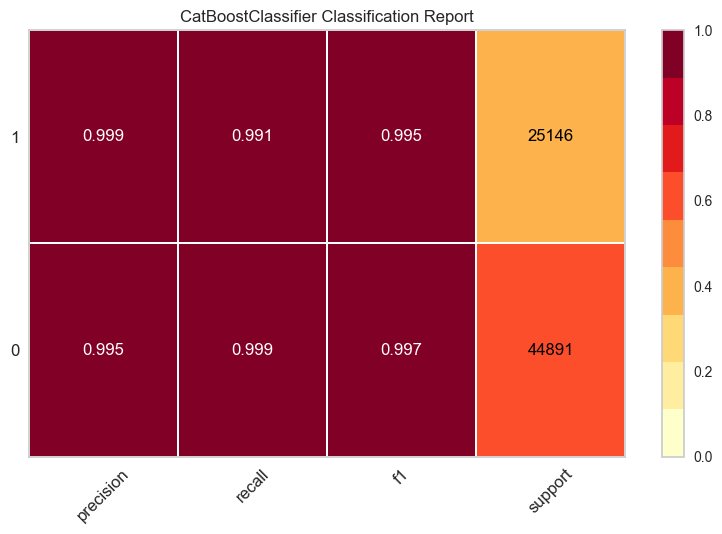

In [81]:
cc_gan.plot_model(best_synthetic_model, plot='class_report')

In [82]:
pred_gan_df = cc_gan.predict_model(best_synthetic_model, data=test_df.copy().drop('Class', axis=1))

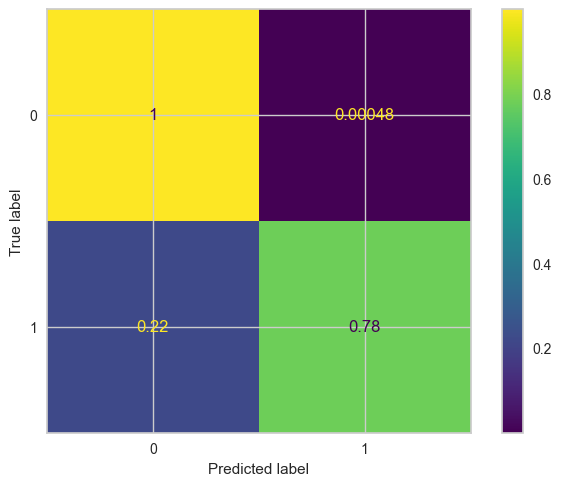

In [85]:
ConfusionMatrixDisplay.from_predictions(test_df['Class'], pred_gan_df['prediction_label'], normalize="true")

In [86]:
print(classification_report(test_df['Class'], pred_gan_df['prediction_label']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59865
           1       0.67      0.78      0.72        77

    accuracy                           1.00     59942
   macro avg       0.84      0.89      0.86     59942
weighted avg       1.00      1.00      1.00     59942



# WGAN

In [19]:
class FraudDataset(Dataset):
    def __init__(self, in_df):
        self.df = in_df[in_df['Class'] == 1].copy()
        self.x_train = torch.Tensor(self.df.drop(['Class'], axis=1).values).to(DEVICE)
        self.features = self.x_train.shape[1]

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.x_train[idx]

In [20]:
class Generator(nn.Module):
    def __init__(self, latent_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
        )

    def forward(self, x):
        return self.model(x)

In [21]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        return self.model(x)

In [370]:
class WGAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.00005
        self.batch_size = 16
        self.n_critic = 5
        self.clip_value = 0.01

        self.dataset = FraudDataset(train_df)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_size=latent_size, output_size=self.dataset.features).to(DEVICE)
        self.D = Discriminator(input_size=self.dataset.features).to(DEVICE)
        self.latent_size = latent_size

        self.g_optimizer = optim.RMSprop(self.G.parameters(), lr=self.lr)
        self.d_optimizer = optim.RMSprop(self.D.parameters(), lr=self.lr)

    def train(self, epochs=1000):
        g_losses = []
        d_losses = []
        for epoch in range(epochs):
            for i, real_frauds in enumerate(self.dataloader):
                # Train Discriminator
                self.d_optimizer.zero_grad()
                z = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (real_frauds.shape[0], self.latent_size))).to(DEVICE))
                fake_frauds = self.G(z).detach()
                # Adversarial Loss
                loss_D = -torch.mean(self.D(real_frauds)) + torch.mean(self.D(fake_frauds))
                loss_D.backward()
                self.d_optimizer.step()

                # Clip weights of discriminator
                for p in self.D.parameters():
                    p.data.clamp_(-self.clip_value, self.clip_value)

                # Train the generator every n_critic iterations
                if i % self.n_critic == 0:
                    # Train Generator
                    self.g_optimizer.zero_grad()
                    gen_frauds = self.G(z)
                    # Adversarial Loss
                    loss_G = -torch.mean(self.D(gen_frauds))
                    loss_G.backward()
                    self.g_optimizer.step()
            print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, epochs, loss_D.item(), loss_G.item()))
            g_losses.append(loss_G.item())
            d_losses.append(loss_D.item())
        return pd.DataFrame({
            'Generator Loss': g_losses,
            'Discriminator Loss': d_losses,
        })

    def sample(self, count):
        with torch.no_grad():
            z = torch.Tensor(np.random.normal(0, 1, (count, self.latent_size))).to(DEVICE)
            gen = self.G(z)
            return gen.cpu().numpy()

In [371]:
wgan = WGAN(train_df)

[Epoch 0/5000] [D loss: -243.623398] [G loss: -0.005838]
[Epoch 1/5000] [D loss: -701.601257] [G loss: -0.067794]
[Epoch 2/5000] [D loss: -1189.307495] [G loss: -0.308903]
[Epoch 3/5000] [D loss: -1805.607422] [G loss: -0.640746]
[Epoch 4/5000] [D loss: -2626.614258] [G loss: -1.199827]
[Epoch 5/5000] [D loss: -4212.275879] [G loss: -2.298961]
[Epoch 6/5000] [D loss: -5269.284668] [G loss: -3.701961]
[Epoch 7/5000] [D loss: -6432.529785] [G loss: -5.342770]
[Epoch 8/5000] [D loss: -6703.971680] [G loss: -7.681534]
[Epoch 9/5000] [D loss: -7192.572266] [G loss: -10.260241]
[Epoch 10/5000] [D loss: -6936.180664] [G loss: -12.540482]
[Epoch 11/5000] [D loss: -6620.562012] [G loss: -15.590429]
[Epoch 12/5000] [D loss: -7454.648438] [G loss: -18.901318]
[Epoch 13/5000] [D loss: -8397.253906] [G loss: -21.481405]
[Epoch 14/5000] [D loss: -7565.254395] [G loss: -23.864454]
[Epoch 15/5000] [D loss: -6505.980469] [G loss: -26.995697]
[Epoch 16/5000] [D loss: -9289.861328] [G loss: -29.794586]
[

<AxesSubplot: title={'center': 'Epoch Losses'}>

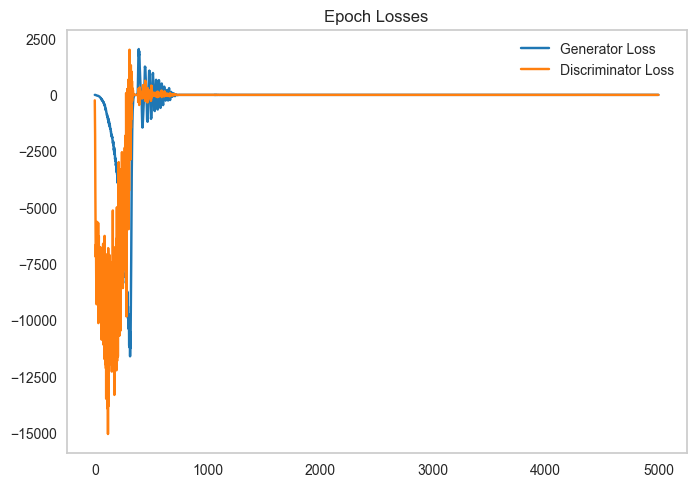

In [372]:
wgan_loss_df = wgan.train(epochs=5000)
wgan_loss_df.plot(title='Epoch Losses', grid=False, color=['tab:blue', 'tab:orange'])

In [373]:
wgan_nsamples = train_df[train_df['Class'] == 0]['Class'].value_counts()[0]
wgan_samples = wgan.sample(wgan_nsamples)
wgan_samples = np.append(wgan_samples, np.ones((wgan_nsamples, 1)), axis=1)
wgan_df = pd.DataFrame(wgan_samples, columns=train_df.columns)

In [374]:
wgan_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,59587.632812,-110.431740,71.070717,-20.015434,23.665621,-63.541714,-79.005508,-71.813751,-3.790282,23.731867,...,53.806320,184.463791,-21.107229,63.050793,43.283211,-4.559671,-16.322563,13.788429,253.344177,1.0
1,79117.820312,-146.621170,94.312325,-26.558922,31.368422,-84.397728,-104.843185,-95.178741,-5.144607,31.575190,...,71.290756,244.904739,-27.937056,83.757698,57.508858,-6.161737,-21.629326,18.370644,336.541901,1.0
2,62339.535156,-115.477699,74.367134,-20.987480,24.624907,-66.597191,-82.571335,-75.039642,-3.853393,24.830652,...,56.291321,193.104568,-21.961149,65.986855,45.295082,-4.796426,-17.061943,14.441566,265.125153,1.0
3,72623.234375,-134.676758,86.672066,-24.251671,28.766172,-77.490868,-96.270813,-87.372742,-4.644469,28.897760,...,65.540909,224.787003,-25.783255,76.948402,52.771950,-5.646753,-19.889336,16.801460,308.799042,1.0
4,59505.375000,-110.254478,70.931404,-19.883141,23.498121,-63.439663,-78.945465,-71.629517,-3.846343,23.788446,...,53.775909,184.137680,-21.182653,62.970257,43.149841,-4.543252,-16.294212,13.808784,253.039551,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224445,64441.078125,-119.449310,77.001869,-21.668785,25.650320,-68.719566,-85.495956,-77.608490,-4.135802,25.713099,...,58.146042,199.488052,-22.873991,68.233528,46.933212,-5.081415,-17.568748,14.862129,273.920013,1.0
224446,76662.445312,-142.270905,91.415016,-25.701378,30.385687,-81.757286,-101.605301,-92.268494,-4.897964,30.618769,...,69.258072,237.221695,-27.179625,81.257637,55.786797,-6.007822,-20.939995,17.802040,326.125031,1.0
224447,41498.445312,-77.044586,49.590492,-13.920860,16.472525,-44.272335,-55.054184,-49.895523,-2.617751,16.534327,...,37.437462,128.513336,-14.694689,43.949291,30.202656,-3.174470,-11.322227,9.684502,176.472000,1.0
224448,58057.468750,-107.674194,69.207069,-19.433098,23.060015,-61.980495,-76.951630,-69.816010,-3.698287,23.129297,...,52.525246,179.729630,-20.583082,61.433147,42.178619,-4.534341,-16.012047,13.416206,246.897339,1.0


In [375]:
wgan_train_df = pd.concat([train_df, wgan_df], ignore_index=True)
wgan_train_df['Class'].value_counts()

1.0    224865
0.0    224450
Name: Class, dtype: int64

In [98]:
cc_wgan = setup(data=wgan_train_df, target='Class', session_id=42, train_size=0.80)

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(448900, 31)"
4,Transformed data shape,"(448900, 31)"
5,Transformed train set shape,"(359120, 31)"
6,Transformed test set shape,"(89780, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


In [99]:
best_wgan_model = cc_wgan.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9997,1.0000,0.9996,0.9999,0.9997,0.9995,0.9995,10.3870
rf,Random Forest Classifier,0.9998,0.9999,0.9996,0.9999,0.9998,0.9995,0.9995,12.2690
ada,Ada Boost Classifier,0.9995,0.9999,0.9994,0.9996,0.9995,0.9990,0.9990,9.9960
gbc,Gradient Boosting Classifier,0.9997,0.9999,0.9995,0.9998,0.9997,0.9993,0.9993,50.3840
et,Extra Trees Classifier,0.9997,0.9999,0.9996,0.9999,0.9997,0.9995,0.9995,5.8560
lightgbm,Light Gradient Boosting Machine,0.9998,0.9999,0.9996,0.9999,0.9998,0.9995,0.9995,0.6440
dt,Decision Tree Classifier,0.9995,0.9995,0.9995,0.9994,0.9995,0.9989,0.9989,1.5090
qda,Quadratic Discriminant Analysis,0.9994,0.9994,0.9989,0.9999,0.9994,0.9988,0.9988,0.3440
lr,Logistic Regression,0.9973,0.9993,0.9991,0.9955,0.9973,0.9946,0.9946,2.5310
knn,K Neighbors Classifier,0.9987,0.9991,0.9982,0.9992,0.9987,0.9975,0.9975,8.4290


In [100]:
pred_wgan_df = cc_wgan.predict_model(best_wgan_model, data=test_df.copy().drop('Class', axis=1))

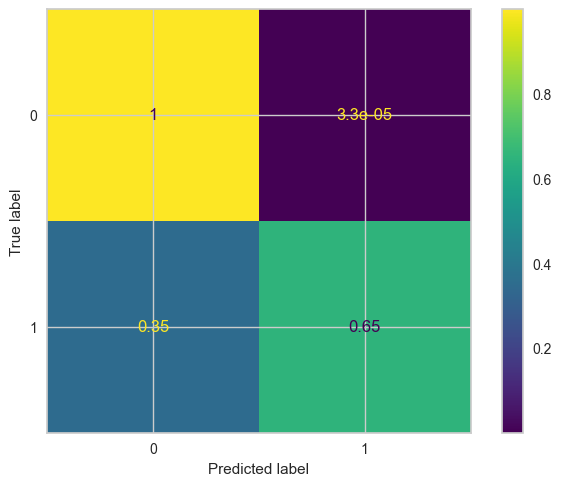

In [101]:
ConfusionMatrixDisplay.from_predictions(test_df['Class'], pred_wgan_df['prediction_label'], normalize="true")

In [102]:
print(classification_report(test_df['Class'], pred_wgan_df['prediction_label']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59865
           1       0.96      0.65      0.78        77

    accuracy                           1.00     59942
   macro avg       0.98      0.82      0.89     59942
weighted avg       1.00      1.00      1.00     59942



# NN Model

In [106]:
class CardDataset(Dataset):
    def __init__(self, in_df):
        self.df = in_df.copy()
        x = self.df.drop(['Class'], axis=1).values
        y = self.df['Class'].values
        self.x_train = torch.Tensor(x).to(DEVICE)
        self.y_train = torch.Tensor(y).to(DEVICE)
        self.features = x.shape[1]

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

In [273]:
class Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [274]:
class FraudModel:
    def __init__(self, train_df):
        self.lr = 0.0001
        self.batch_size = 64
        self.dataset = CardDataset(train_df)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = Model(input_size=self.dataset.features).to(DEVICE)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(self.dataloader):
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()
        
    def evaluate(self, test_df, confidence=0.50):
        input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(DEVICE)
        preds = self.predict(input)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1
        ConfusionMatrixDisplay.from_predictions(test_df['Class'].values, labels, normalize='true')
        RocCurveDisplay.from_predictions(test_df['Class'].values, labels)
        print(classification_report(test_df['Class'].values, labels))

[Epoch 0/100] loss: 1.462310
[Epoch 1/100] loss: 0.733292
[Epoch 2/100] loss: 0.472149
[Epoch 3/100] loss: 0.337919
[Epoch 4/100] loss: 0.306519
[Epoch 5/100] loss: 0.279501
[Epoch 6/100] loss: 0.358065
[Epoch 7/100] loss: 0.369644
[Epoch 8/100] loss: 0.326445
[Epoch 9/100] loss: 0.292704
[Epoch 10/100] loss: 0.319446
[Epoch 11/100] loss: 0.305003
[Epoch 12/100] loss: 0.299356
[Epoch 13/100] loss: 0.295193
[Epoch 14/100] loss: 0.295498
[Epoch 15/100] loss: 0.280957
[Epoch 16/100] loss: 0.243145
[Epoch 17/100] loss: 0.235951
[Epoch 18/100] loss: 0.247594
[Epoch 19/100] loss: 0.271487
[Epoch 20/100] loss: 0.248447
[Epoch 21/100] loss: 0.257312
[Epoch 22/100] loss: 0.243942
[Epoch 23/100] loss: 0.266987
[Epoch 24/100] loss: 0.229456
[Epoch 25/100] loss: 0.219887
[Epoch 26/100] loss: 0.232935
[Epoch 27/100] loss: 0.229540
[Epoch 28/100] loss: 0.271291
[Epoch 29/100] loss: 0.245451
[Epoch 30/100] loss: 0.241436
[Epoch 31/100] loss: 0.231499
[Epoch 32/100] loss: 0.234716
[Epoch 33/100] loss:

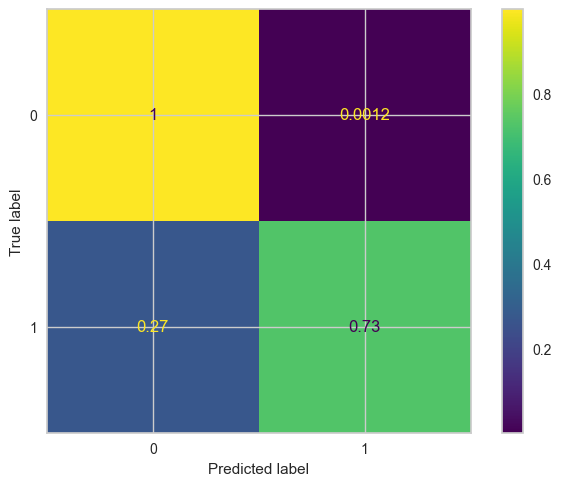

In [275]:
fb_model = FraudModel(train_df)
fb_model.train(epochs=100)
fb_model.evaluate(test_df, confidence=0.90)

[Epoch 0/100] loss: 22.396232
[Epoch 1/100] loss: 16.970010
[Epoch 2/100] loss: 16.217909
[Epoch 3/100] loss: 15.772845
[Epoch 4/100] loss: 15.525131
[Epoch 5/100] loss: 14.966168
[Epoch 6/100] loss: 14.614338
[Epoch 7/100] loss: 14.123138
[Epoch 8/100] loss: 13.859429
[Epoch 9/100] loss: 13.551918
[Epoch 10/100] loss: 13.285500
[Epoch 11/100] loss: 13.065232
[Epoch 12/100] loss: 13.010144
[Epoch 13/100] loss: 12.702908
[Epoch 14/100] loss: 12.473321
[Epoch 15/100] loss: 12.113997
[Epoch 16/100] loss: 11.606338
[Epoch 17/100] loss: 11.065031
[Epoch 18/100] loss: 10.443915
[Epoch 19/100] loss: 10.367779
[Epoch 20/100] loss: 9.667859
[Epoch 21/100] loss: 9.192784
[Epoch 22/100] loss: 8.864924
[Epoch 23/100] loss: 8.748453
[Epoch 24/100] loss: 8.463852
[Epoch 25/100] loss: 8.093347
[Epoch 26/100] loss: 7.869423
[Epoch 27/100] loss: 7.554344
[Epoch 28/100] loss: 7.119982
[Epoch 29/100] loss: 7.029984
[Epoch 30/100] loss: 7.056934
[Epoch 31/100] loss: 6.852385
[Epoch 32/100] loss: 6.825738


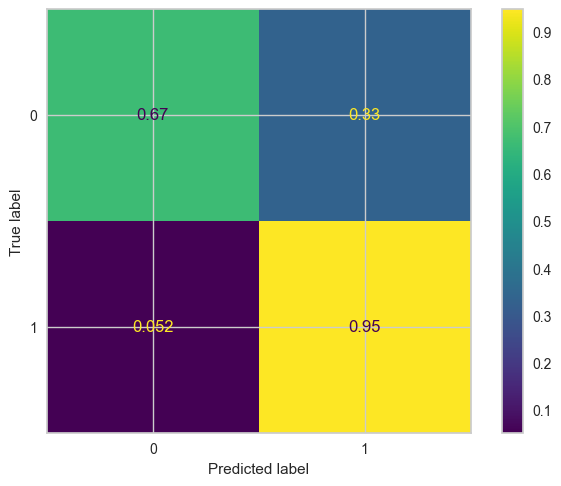

In [276]:
fs_model = FraudModel(gan_train_df)
fs_model.train(epochs=100)
fs_model.evaluate(test_df, confidence=0.90)

[Epoch 0/100] loss: 1.194037
[Epoch 1/100] loss: 0.644622
[Epoch 2/100] loss: 0.585414
[Epoch 3/100] loss: 0.513411
[Epoch 4/100] loss: 0.513256
[Epoch 5/100] loss: 0.455931
[Epoch 6/100] loss: 0.438029
[Epoch 7/100] loss: 0.418130
[Epoch 8/100] loss: 0.363587
[Epoch 9/100] loss: 0.328736
[Epoch 10/100] loss: 0.319445
[Epoch 11/100] loss: 0.292724
[Epoch 12/100] loss: 0.294222
[Epoch 13/100] loss: 0.276103
[Epoch 14/100] loss: 0.276075
[Epoch 15/100] loss: 0.277243
[Epoch 16/100] loss: 0.250314
[Epoch 17/100] loss: 0.242306
[Epoch 18/100] loss: 0.242483
[Epoch 19/100] loss: 0.248041
[Epoch 20/100] loss: 0.259339
[Epoch 21/100] loss: 0.252611
[Epoch 22/100] loss: 0.250701
[Epoch 23/100] loss: 0.246788
[Epoch 24/100] loss: 0.219472
[Epoch 25/100] loss: 0.230887
[Epoch 26/100] loss: 0.226886
[Epoch 27/100] loss: 0.242007
[Epoch 28/100] loss: 0.222073
[Epoch 29/100] loss: 0.234604
[Epoch 30/100] loss: 0.226764
[Epoch 31/100] loss: 0.224640
[Epoch 32/100] loss: 0.219063
[Epoch 33/100] loss:

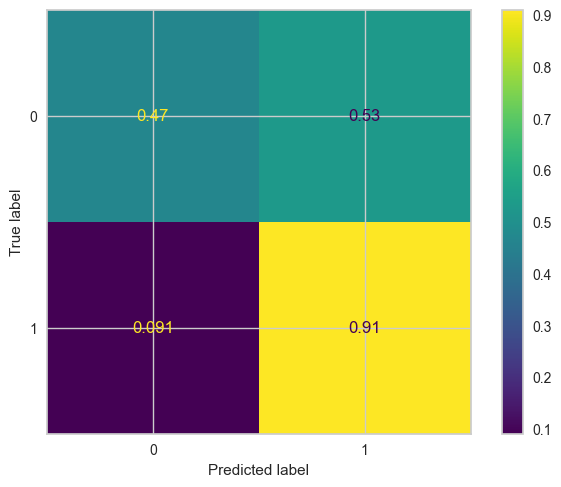

In [360]:
fw_model = FraudModel(wgan_train_df)
fw_model.train(epochs=100)
fw_model.evaluate(test_df, confidence=0.90)

# Anomaly Detection WGAN

In [119]:
class BinaryDiscriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [121]:
class AnomalyWGAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.00005
        self.a_lr = 0.0002
        self.batch_size = 64
        self.n_critic = 5
        self.clip_value = 0.01

        self.dataset = CardDataset(train_df)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_size=latent_size, output_size=self.dataset.features).to(DEVICE)
        self.D = Discriminator(input_size=self.dataset.features).to(DEVICE)
        self.D_2 = BinaryDiscriminator(input_size=self.dataset.features).to(DEVICE)
        self.latent_size = latent_size

        self.g_optimizer = optim.RMSprop(self.G.parameters(), lr=self.lr)
        self.d_optimizer = optim.RMSprop(self.D.parameters(), lr=self.lr)
        self.d_2_optimizer = optim.Adam(self.D_2.parameters(), lr=self.a_lr)
        self.criterion = nn.BCELoss()

    def train(self, epochs=1000):
        g_losses = []
        d_losses = []
        d_2_losses = []
        for epoch in range(epochs):
            for i, (real_ops, real_labels) in enumerate(self.dataloader):
                # Label smoothing
                real_label = torch.ones(real_ops.shape[0]).to(DEVICE) * 0.90 * (1.0 - real_labels)
                fake_label = torch.ones(real_ops.shape[0]).to(DEVICE) * 0.10

                # Train Discriminator
                self.d_optimizer.zero_grad()
                z = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (real_ops.shape[0], self.latent_size))).to(DEVICE))
                fake_ops = self.G(z).detach()

                # Adversarial Loss
                loss_D = -torch.mean(self.D(real_ops)) + torch.mean(self.D(fake_ops))
                loss_D.backward()
                self.d_optimizer.step()

                # Clip weights of discriminator
                for p in self.D.parameters():
                    p.data.clamp_(-self.clip_value, self.clip_value)

                # Train Binary Discriminator
                self.d_2_optimizer.zero_grad()
                loss_D_2 = 0.50 * (self.criterion(self.D_2(real_ops), real_label) + self.criterion(self.D_2(fake_ops), fake_label))
                loss_D_2.backward()
                self.d_2_optimizer.step()

                # Train the generator every n_critic iterations
                if i % self.n_critic == 0:
                    # Train Generator
                    self.g_optimizer.zero_grad()
                    gen_ops = self.G(z)

                    # Adversarial Loss
                    loss_G = -torch.mean(self.D(gen_ops))
                    loss_G.backward()
                    self.g_optimizer.step()

            print("[Epoch %d/%d] [D loss: %f] [D_2 loss: %f] [G loss: %f]" % (epoch, epochs, loss_D.item(), loss_D_2.item(), loss_G.item()))
            g_losses.append(loss_G.item())
            d_losses.append(loss_D.item())
            d_2_losses.append(loss_D_2.item())

        return pd.DataFrame({
            'Generator Loss': g_losses,
            'Discriminator Loss': d_losses,
            'Binary Discriminator Loss': d_2_losses,
        })

    def predict(self, x):
        with torch.no_grad():
            preds = self.D_2(x)
            return preds.cpu().numpy()
        
    def evaluate(self, test_df, confidence=0.50):
        input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(DEVICE)
        preds = self.predict(input)
        labels = np.ones_like(preds)
        labels[preds >= confidence] = 0
        ConfusionMatrixDisplay.from_predictions(test_df['Class'].values, labels, normalize='true')
        RocCurveDisplay.from_predictions(test_df['Class'].values, labels)
        print(classification_report(test_df['Class'].values, labels))

In [122]:
awgan = AnomalyWGAN(train_df)

[Epoch 0/200] [D loss: -18015.765625] [D_2 loss: 0.330721] [G loss: -1980.314209]
[Epoch 1/200] [D loss: -16126.121094] [D_2 loss: 0.362280] [G loss: -12751.151367]
[Epoch 2/200] [D loss: 61.202148] [D_2 loss: 0.327532] [G loss: 2150.680664]
[Epoch 3/200] [D loss: 42.029785] [D_2 loss: 0.333319] [G loss: -609.970520]
[Epoch 4/200] [D loss: 202.907471] [D_2 loss: 0.326577] [G loss: 967.671875]
[Epoch 5/200] [D loss: -25.324951] [D_2 loss: 0.326046] [G loss: -1622.306396]
[Epoch 6/200] [D loss: 11.570015] [D_2 loss: 0.325761] [G loss: 151.375549]
[Epoch 7/200] [D loss: -8.655365] [D_2 loss: 0.326277] [G loss: -116.714630]
[Epoch 8/200] [D loss: 105.326233] [D_2 loss: 0.325606] [G loss: 1040.507080]
[Epoch 9/200] [D loss: 18.386658] [D_2 loss: 0.325469] [G loss: 375.997070]
[Epoch 10/200] [D loss: 273.395508] [D_2 loss: 0.325924] [G loss: -1634.744141]
[Epoch 11/200] [D loss: -77.909576] [D_2 loss: 0.325273] [G loss: 590.113525]
[Epoch 12/200] [D loss: -8.608521] [D_2 loss: 0.325410] [G l

<AxesSubplot: title={'center': 'Epoch Losses'}>

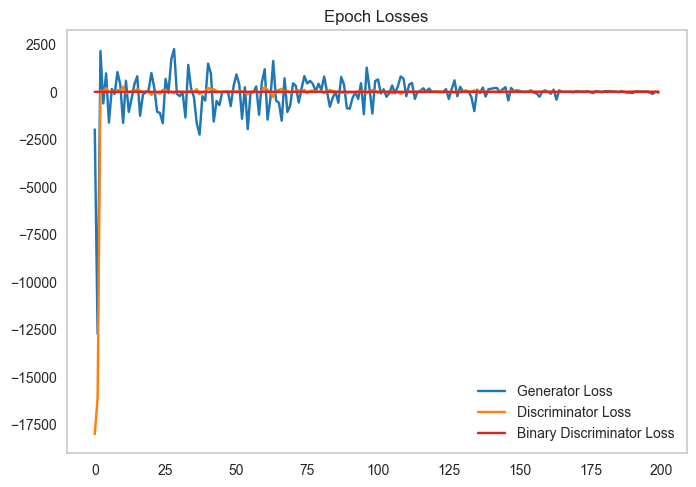

In [123]:
awgan_loss_df = awgan.train(epochs=200)
awgan_loss_df.plot(title='Epoch Losses', grid=False, color=['tab:blue', 'tab:orange', 'tab:red'])

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     59865
           1       0.01      0.94      0.03        77

    accuracy                           0.91     59942
   macro avg       0.51      0.92      0.49     59942
weighted avg       1.00      0.91      0.95     59942



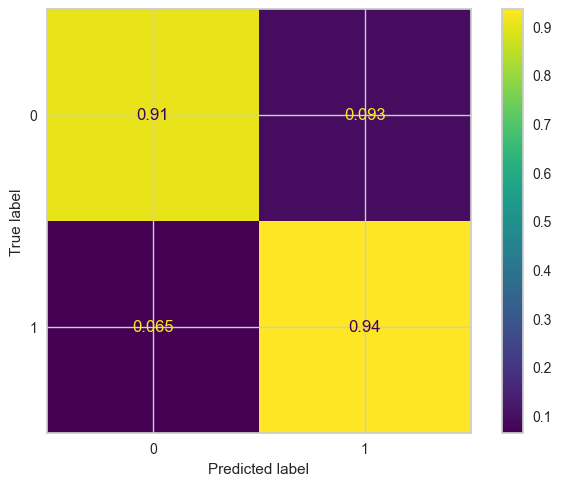

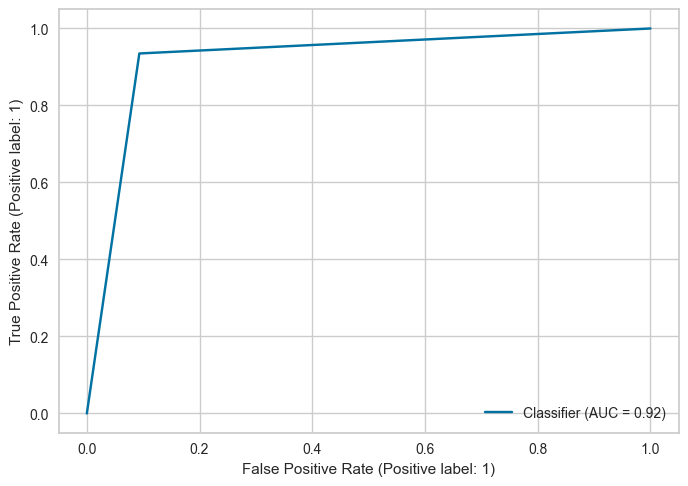

In [127]:
awgan.evaluate(test_df, confidence=0.85)